# BERT - Climate Sentiment Multiclass Classification
## CS522 Project

**Dataset:**  
https://www.kaggle.com/code/luiskalckstein/climate-sentiment-multiclass-classification

**Imports**

In [1]:
# ! pip install tensorflow-addons
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from transformers import logging as hf_logging
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from Common.UtilFuncs import DataSize
from Common.DataCenter import data_center

hf_logging.set_verbosity_error()
warnings.filterwarnings('ignore')

TrainSizeBaseLine = DataSize.GetTrainSizeBaseline()
TrainSizeWithNoisyData = DataSize.GetTrainSizeWithNoisyData()
TestDataSize = DataSize.GetTestDataSize()
NoiseDataSize = DataSize.GetNoiseDataSize()
ValidationDataSize = DataSize.GetValidationDataSize()

%matplotlib inline

**Detect GPU**

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print('Set memory autoincrement')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print('Physical GPUs: %d, Logical GPUs: %d' % (len(gpus), len(logical_gpus)))
  except RuntimeError as e:
    print(e)
else:
    print('GPUs not detected')

Set memory autoincrement
Physical GPUs: 1, Logical GPUs: 1


## 1. Loading Dataset

In [3]:
def dc_format(D):
    data = {'message':D[0] , 'sentiment':D[1]}
    df = pd.DataFrame(data)
    return df

In [4]:
dc = data_center('./twitter_sentiment_data_clean.csv', test_size=TestDataSize, noisy_size=NoiseDataSize, validation_size=ValidationDataSize)
test_df = dc_format(dc.get_test())
val_df = dc_format(dc.get_validation())

print(f"Test size: {test_df.shape[0]}")
print(f"Validation size: {val_df.shape[0]}")

Test size: 4000
Validation size: 1000


In [5]:
# 6000
train_df_6000 = dc_format(dc.get_train(TrainSizeBaseLine[0]))
# 7500
train_df_7500 = dc_format(dc.get_train(TrainSizeBaseLine[1]))
# 12000
train_df_12000 = dc_format(dc.get_train(TrainSizeBaseLine[2]))
# 15000
train_df_15000 = dc_format(dc.get_train(TrainSizeBaseLine[3]))
# 22500
train_df_22500 = dc_format(dc.get_train(TrainSizeBaseLine[4]))
# 30000
train_df_30000 = dc_format(dc.get_train(TrainSizeBaseLine[5]))

In [6]:
# (6000, 1500)
train_df_6000_1500 = dc_format(dc.get_train_with_noisy(TrainSizeWithNoisyData[0][0],TrainSizeWithNoisyData[0][1]))
# (12000, 3000)
train_df_12000_3000 = dc_format(dc.get_train_with_noisy(TrainSizeWithNoisyData[1][0],TrainSizeWithNoisyData[1][1]))
# (22500, 7500)
#train_df_22500_7500 = dc_format(dc.get_train_with_noisy(TrainSizeWithNoisyData[2][0],TrainSizeWithNoisyData[2][1]))

### <font color='red'> Specified training set </font>

In [7]:
train_df = train_df_7500

In [8]:
train_df.head()

,message,sentiment
0,"But hey, climate change is a hoax anyway so th...",2
1,@zakomano him and his batch of extremists that...,2
2,Lloyd's of London to divest from coal over cli...,3
3,@ChristianLeave global warming be like that ya...,1
4,RT @TheSpinoffTV: 'Bill English says Kiwis don...,2


#### Label Encoding

In [9]:
le = LabelEncoder()
train_df['sparse_label'] = le.fit_transform(train_df['sentiment'])
val_df['sparse_label'] = le.transform(val_df['sentiment'])
test_df['sparse_label'] = le.transform(test_df['sentiment'])

In [10]:
label_dict = (train_df[['sentiment','sparse_label']].drop_duplicates()
              .sort_values(by='sparse_label')
              .reset_index(drop=True)['sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 0
1 1
2 2
3 3


#### Splitting dataset

In [11]:
x_train = train_df['message']
y_train = train_df['sparse_label']

x_val = val_df['message']
y_val = val_df['sparse_label']

print(f"{len(x_train)} training samples\n{len(x_val)} validation samples")

7500 training samples
1000 validation samples


In [12]:
x_test = test_df['message']
y_test = test_df['sparse_label']
print(f"{len(x_test)} testing samples")

4000 testing samples


## 2. Train BERT

In [13]:
MODEL_NAME = 'distilbert-base-uncased'

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [15]:
max_len = 0
for sentence in (x_train.tolist() + x_val.tolist()):
    try:
        sentence_token_len = len(tokenizer.tokenize(sentence))
        max_len = sentence_token_len if (sentence_token_len > max_len) else max_len
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_len}")

The maximum amount of tokens in the dataset is 100


In [16]:
MAX_LEN = 365

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LEN, 
                                                pad_to_max_length=True)

def tokenize(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LEN, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])       
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [17]:
X_train = tokenize(x_train)
X_val = tokenize(x_val)
X_test = tokenize(x_test)

100%|██████████| 4000/4000 [00:02<00:00, 1364.38it/s]


#### Add custom layers after embedding model for classification

In [18]:
bert_config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
TFBert = TFDistilBertModel.from_pretrained(MODEL_NAME, config=bert_config)

input_ids_layer = tf.keras.layers.Input(shape=(MAX_LEN,), name='input_token', dtype='int32')
input_masks_layer = tf.keras.layers.Input(shape=(MAX_LEN,), name='masked_token', dtype='int32') 

X = TFBert(input_ids = input_ids_layer, attention_mask = input_masks_layer)[0]
# X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(X)
# X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(X)
# X = tf.keras.layers.Dropout(0.3)(X)
X = tf.keras.layers.Dense(1024, activation=tfa.activations.mish)(X)
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(4, activation=tf.nn.softmax)(X)

model = tf.keras.Model(inputs=[input_ids_layer, input_masks_layer], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = True

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 365)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 365)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 365, 768),                                                   
                                 hidden_states=((No                                           

#### Model callbacks

In [20]:
ckpt_dir = './ckpt'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

In [21]:
model_checkpoint = ModelCheckpoint(filepath=ckpt_dir + '/weights_val_best.hdf5',
                                   monitor='val_accuracy',
                                   save_weights_only=True,
                                   save_best_only=True,
                                   verbose=0)

early_stopping = EarlyStopping(patience=3,
                               monitor='val_accuracy',
                               min_delta=0,
                               mode='min',
                               restore_best_weights=False,
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              min_lr=0.000001,
                              patience=1,
                              mode='min',
                              factor=0.1,
                              min_delta=0.0001,
                              verbose=1)

In [22]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tfa.optimizers.RectifiedAdam(0.0001),
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=8,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/50
938/938 [==============================] - 304s 310ms/step - loss: 0.9580 - accuracy: 0.6137 - val_loss: 0.9121 - val_accuracy: 0.6130 - lr: 1.0000e-04
Epoch 2/50
938/938 [==============================] - 300s 320ms/step - loss: 0.6876 - accuracy: 0.7327 - val_loss: 0.8083 - val_accuracy: 0.6870 - lr: 1.0000e-04
Epoch 3/50
938/938 [==============================] - ETA: 0s - loss: 0.4208 - accuracy: 0.8497
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
938/938 [==============================] - 282s 301ms/step - loss: 0.4208 - accuracy: 0.8497 - val_loss: 0.8621 - val_accuracy: 0.7270 - lr: 1.0000e-04
Epoch 4/50
938/938 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9680
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 [==============================] - 309s 329ms/step - loss: 0.0958 - accuracy: 0.9680 - val_loss: 1.1292 - val_accuracy: 0.7300 - lr: 1.0000e-05
Epoch 4: early stopping


In [23]:
def plot_graphs(history, metric, title=''):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[metric],  label='Training')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.show()

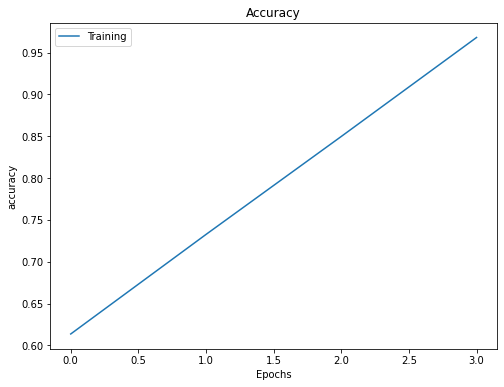

In [24]:
plot_graphs(history, 'accuracy', 'Accuracy')

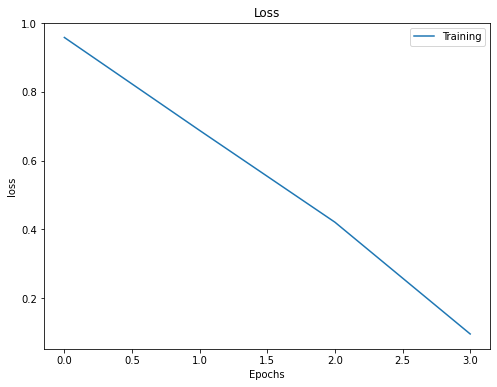

In [25]:
plot_graphs(history, 'loss', 'Loss')

#### Loading the best model and test on a test set

In [26]:
model.load_weights(ckpt_dir + '/weights_val_best.hdf5')

In [27]:
pred_probs = model.predict(X_test)
y_pred = np.argmax(pred_probs, axis=1)

#### Visualizing Confusion Matrix using Heatmap

In [28]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 146,   75,  135,   20],
       [  49,  313,  320,   50],
       [  34,  138, 1697,  140],
       [   5,   25,  154,  699]], dtype=int64)

Test Accuracy: 0.71375


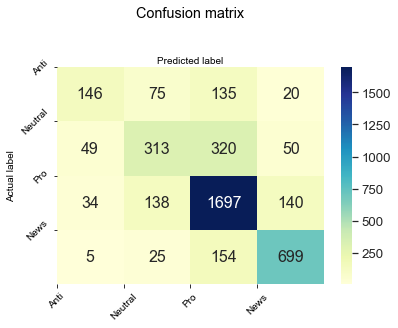

In [29]:
labels_names = ['Anti','Neutral','Pro','News'] 
class_names=[0, 1, 2, 3]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

sns.set(font_scale = 1.2, color_codes=True, palette='deep')
sns.heatmap(pd.DataFrame(cm, index=labels_names ,columns=class_names), annot=True, annot_kws = {'size':16}, cmap='YlGnBu' ,fmt='g')
ax.xaxis.set_label_position('top')
plt.xticks(class_names, labels_names, rotation=45)
plt.yticks(class_names, labels_names, rotation=45)
plt.title('Confusion matrix', y=1.2)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Test Accuracy:', accuracy_score(y_test, y_pred))

In [30]:
print(classification_report(y_test, y_pred, target_names=labels_names))

              precision    recall  f1-score   support

        Anti       0.62      0.39      0.48       376
     Neutral       0.57      0.43      0.49       732
         Pro       0.74      0.84      0.79      2009
        News       0.77      0.79      0.78       883

    accuracy                           0.71      4000
   macro avg       0.67      0.61      0.63      4000
weighted avg       0.70      0.71      0.70      4000



In [31]:
mf = f1_score(y_test, y_pred, average='macro')
wf = f1_score(y_test, y_pred, average='weighted')
mp = precision_score(y_test, y_pred, average='macro')
mr = recall_score(y_test, y_pred, average='macro')

In [32]:
print(
    f'Macro F1: {mf: .3f} \
    | Weighted F1: {wf: .3f} \
    | Macro Precision: {mp: .3f} \
    | Macro recall: {mr: .3f}'
)

Macro F1:  0.633     | Weighted F1:  0.702     | Macro Precision:  0.674     | Macro recall:  0.613
